<a href="https://colab.research.google.com/github/vasiliyeskin/MachineLearningExperiences/blob/master/text%20analysis/dl_nlp_yelp_polarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Определение тональности текстов отзывов на сайте [YELP](https://www.yelp.com/dataset/challenge) сетью LSTM

Учебный курс "[Нейросети для анализа текстов](https://www.asozykin.ru/courses/nnpython)".

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

Не забудьте подключить GPU, чтобы сеть обучалась быстрее (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU).

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

TensorFlow 2.x selected.


In [ ]:
num_words = 10000
max_review_len = 100

## Загрузка набора данных

In [ ]:
!wget https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1 -O yelp_review_polarity_csv.tgz

--2020-01-18 16:25:30--  https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz [following]
--2020-01-18 16:25:35--  https://www.dropbox.com/s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4daa01e2c06b226bc1f89f3bc9.dl.dropboxusercontent.com/cd/0/get/Awa6xfw2_vS3Qp9p9_o8FANCCfi2aZXYpovHMGAAF30KRodQeFOrS11NuQFITeXiDaOSJP0HQjHXKRjVmFU50ICzGATElyJfLd-WkDciVOS87vm1Dp_mNVWtwxvz8ZPe-MU/file?dl=1# [following]
--2020-01-18 16:25:35--  https://uc4daa01e2c06b226bc1f89f3bc9.dl.dropboxusercontent.com/cd/0/get/Awa6xfw2_vS3Qp9p9_o8FANCCfi2aZXYpovHMGAAF30KRodQeFOrS11NuQFITeXi

In [ ]:
!tar -xvf yelp_review_polarity_csv.tgz

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


## Просматриваем данные

In [ ]:
!cat yelp_review_polarity_csv/readme.txt

Yelp Review Polarity Dataset

Version 1, Updated 09/09/2015

ORIGIN

The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset_challenge

The Yelp reviews polarity dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset. It is first used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).


DESCRIPTION

The Yelp reviews polarity dataset is constructed by considering stars 1 and 2 negative, and 3 and 4 positive. For each polarity 280,000 training samples and 19,000 testing samples are take randomly. In total there are 560,000 trainig samples and 38,000 testing samples. Negative polarity is class 1, and positive class 2.

The files train.csv and test.csv contain all the

In [ ]:
!head yelp_review_polarity_csv/train.csv

"1","Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."
"2","Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. H

In [ ]:
!head yelp_review_polarity_csv/test.csv

"2","Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Boys, these guys are experienced and know what they're doing. \nAlso, this is one place that I do not feel like I am being taken advantage of, just because of my gender. Other auto mechanics have been notorious for capitalizing on my ignorance of cars, and have sucked my bank account dry. But here, my service and road coverage has all been well explained - and let up to me to decide. \nAnd they just renovated the waiting room. It looks a lot better than it did in previous years."
"1","Last summer I had an appointment to get new tires and had to wait a super long time. I also went in this week for them to fix a minor problem with a tire they put on. They \""fixed\"" it for free, and the very next morning I had the same issue. I called to complain, and the \""manager\"" didn't even apolog

In [ ]:
!wc -l yelp_review_polarity_csv/train.csv
!wc -l yelp_review_polarity_csv/test.csv

560000 yelp_review_polarity_csv/train.csv
38000 yelp_review_polarity_csv/test.csv


## Загружаем данные в память

Читаем данные из файла

In [ ]:
train = pd.read_csv('yelp_review_polarity_csv/train.csv', 
                    header=None, 
                    names=['Class', 'Review'])

In [ ]:
train

,Class,Review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


Выделяем данные для обучения

In [ ]:
reviews = train['Review']

In [ ]:
reviews[:5]

0    Unfortunately, the frustration of being Dr. Go...
1    Been going to Dr. Goldberg for over 10 years. ...
2    I don't know what Dr. Goldberg was like before...
3    I'm writing this review to give you a heads up...
4    All the food is great here. But the best thing...
Name: Review, dtype: object

Выделяем правильные ответы

In [ ]:
y_train = train['Class'] - 1

In [ ]:
y_train

0         0
1         1
2         0
3         0
4         1
         ..
559995    1
559996    1
559997    0
559998    0
559999    1
Name: Class, Length: 560000, dtype: int64

## Токенизация текста

In [ ]:
reviews[:5]

0    Unfortunately, the frustration of being Dr. Go...
1    Been going to Dr. Goldberg for over 10 years. ...
2    I don't know what Dr. Goldberg was like before...
3    I'm writing this review to give you a heads up...
4    All the food is great here. But the best thing...
Name: Review, dtype: object

Создаем токенизатор Keras

In [ ]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на отзывах Yelp

In [ ]:
tokenizer.fit_on_texts(reviews)

Просматриваем словарь токенизатора

In [ ]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'i': 3,
 'to': 4,
 'a': 5,
 'was': 6,
 'of': 7,
 'it': 8,
 'for': 9,
 'in': 10,
 'is': 11,
 'n': 12,
 'that': 13,
 'my': 14,
 'we': 15,
 'this': 16,
 'but': 17,
 'with': 18,
 'they': 19,
 'you': 20,
 'on': 21,
 'not': 22,
 'have': 23,
 'had': 24,
 'at': 25,
 'were': 26,
 'so': 27,
 'are': 28,
 'food': 29,
 'be': 30,
 'place': 31,
 'me': 32,
 'there': 33,
 'good': 34,
 'as': 35,
 'out': 36,
 'all': 37,
 'like': 38,
 'if': 39,
 'just': 40,
 'our': 41,
 'very': 42,
 'get': 43,
 'one': 44,
 'here': 45,
 'time': 46,
 'when': 47,
 'up': 48,
 'or': 49,
 'from': 50,
 'great': 51,
 'service': 52,
 'would': 53,
 'back': 54,
 'their': 55,
 'about': 56,
 'no': 57,
 'go': 58,
 'an': 59,
 'what': 60,
 'really': 61,
 'he': 62,
 "it's": 63,
 'she': 64,
 'which': 65,
 'will': 66,
 'some': 67,
 'only': 68,
 'been': 69,
 'us': 70,
 'your': 71,
 'because': 72,
 'more': 73,
 'even': 74,
 'can': 75,
 'them': 76,
 'by': 77,
 "don't": 78,
 'got': 79,
 'other': 80,
 'after': 81,
 'do': 8

Преобразуем отзывы Yelp в числовое представление

In [ ]:
sequences = tokenizer.texts_to_sequences(reviews)

Просматриваем отзывы в числовом представлении

In [ ]:
index = 0
print(reviews[index])
print(sequences[index])

Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.
[707, 1, 4339, 7, 173, 939, 1665, 11, 5, 2161, 7, 1, 137, 112, 24, 18, 27, 189, 80, 3128, 10, 2636, 34, 1416, 462, 129, 8, 519, 13, 177, 129, 803, 88, 3812, 1, 446, 8, 392, 841, 115, 360, 7, 4136, 1438, 4, 43, 59, 1266, 118, 95, 46, 9, 13, 49, 1687, 4, 418, 18, 8, 3, 23, 563, 178, 16, 460, 18, 189, 80, 3128, 2, 3, 40, 78, 43, 8, 20, 23, 644, 1343, 20, 23

In [ ]:
tokenizer.word_index['frustration']

4339

Ограничиваем длину отзывов

In [ ]:
x_train = pad_sequences(sequences, maxlen=max_review_len)

In [ ]:
x_train[:5]

array([[   7,    1,  137,  112,   24,   18,   27,  189,   80, 3128,   10,
        2636,   34, 1416,  462,  129,    8,  519,   13,  177,  129,  803,
          88, 3812,    1,  446,    8,  392,  841,  115,  360,    7, 4136,
        1438,    4,   43,   59, 1266,  118,   95,   46,    9,   13,   49,
        1687,    4,  418,   18,    8,    3,   23,  563,  178,   16,  460,
          18,  189,   80, 3128,    2,    3,   40,   78,   43,    8,   20,
          23,  644, 1343,   20,   23, 3252,   18, 2921,  637,  227,  430,
         476, 4312,    1,  446,   63,    2,   22,  215,    1,   63,   18,
        2269,   13,    3,  249,   13,    3,   23,    4,  163,  939,  115,
         237],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   69,  116,
           4,  939,    9,   94,  201,  274,    3,  142,    3,    6,   44,
           7,  177, 2084, 3252,   47,   62,  422,   25, 1334,   69,   51,
          94,    1,  274,    2,   11,   61,   37,   56,    1,  219, 1403,
           8,   11,   7

## Создаем нейронную сеть

In [ ]:
model = Sequential()
model.add(Embedding(num_words, 64, input_length=max_review_len))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

## Обучаем нейронную сеть

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [ ]:
model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=5,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback])

Train on 504000 samples, validate on 56000 samples
Epoch 1/5
503936/504000 [============================>.] - ETA: 0s - loss: 0.2097 - accuracy: 0.9164
Epoch 00001: val_accuracy improved from -inf to 0.95054, saving model to best_model.h5
504000/504000 [==============================] - 76s 151us/sample - loss: 0.2097 - accuracy: 0.9165 - val_loss: 0.1268 - val_accuracy: 0.9505
Epoch 2/5
503680/504000 [============================>.] - ETA: 0s - loss: 0.1446 - accuracy: 0.9443
Epoch 00002: val_accuracy improved from 0.95054 to 0.95636, saving model to best_model.h5
504000/504000 [==============================] - 66s 132us/sample - loss: 0.1446 - accuracy: 0.9443 - val_loss: 0.1158 - val_accuracy: 0.9564
Epoch 3/5
503936/504000 [============================>.] - ETA: 0s - loss: 0.1218 - accuracy: 0.9536
Epoch 00003: val_accuracy improved from 0.95636 to 0.95814, saving model to best_model.h5
504000/504000 [==============================] - 67s 133us/sample - loss: 0.1218 - accuracy: 0.

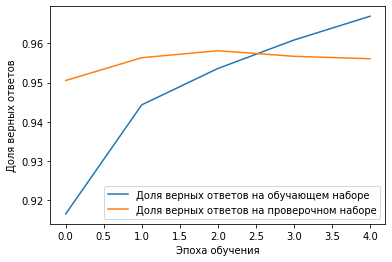

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Загружаем модель с лучшей долей правильных ответов на проверочном наборе данных

In [ ]:
model.load_weights(model_save_path)

## Загружаем набор данных для тестирования

In [ ]:
test = pd.read_csv('yelp_review_polarity_csv/test.csv', 
                    header=None, 
                    names=['Class', 'Review'])

In [ ]:
test

,Class,Review
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...
...,...,...
37995,1,If I could give 0...I would. Don't do it.
37996,2,Items Selected:\nChocolate Cinnamon Horn\nSmal...
37997,1,Expensive lunch meals. Fried pickles were goo...
37998,1,Highly overpriced and food was cold. Our waitr...


Преобразуем отзывы в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['Review'])

In [ ]:
x_test = pad_sequences(test_sequences, maxlen=max_review_len)

In [ ]:
x_test[:5]

array([[   9,    1,  546,  148,  274,  165,    2, 1221,    4,   14,  137,
          18,  289,   38, 8346, 2311,  257,  511,   28, 1167,    2,  113,
          60,  568,  520, 1426,   16,   11,   44,   31,   13,    3,   82,
          22,  249,   38,    3,  144,  173,  694, 2235,    7,   40,   72,
           7,   14,   80, 2540, 5951,   23,   69,    9,   21,   14,    7,
        1558,    2,   23, 1696,   14, 1894, 1775,  470,   17,   45,   14,
          52,    2, 1346, 5923,   95,   37,   69,   91, 1024,    2,  311,
          48,    4,   32,    4, 1480, 1037,   19,   40, 4124,    1,  317,
         127,    8,  562,    5,  203,  114,   99,    8,   90,   10, 1168,
         274],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  182, 1243,    3,   24,
          59,  728,    4,   43,  159, 2073,    2,   24,    4,  154,    5,
         315,  190,   4

Правильные ответы

In [ ]:
y_test = test['Class'] - 1

In [ ]:
y_test

0        1
1        0
2        1
3        0
4        1
        ..
37995    0
37996    1
37997    0
37998    0
37999    0
Name: Class, Length: 38000, dtype: int64

## Оцениваем качество работы сети на тестовом наборе данных

In [ ]:
model.evaluate(x_test, y_test, verbose=1)

38000/38000 [==============================] - 5s 135us/sample - loss: 0.1359 - accuracy: 0.9476


[0.13587481954380085, 0.9476316]

## Оцениваем тональность на собственном отзыве

In [ ]:
text = '''The SmartBurger restaurant is awful. It’s a small shabby place. 
The food is really bad and very expensive.  The host and waiters are rude. 
I will never visit the SmartBurger again!
'''

In [ ]:
sequence = tokenizer.texts_to_sequences([text])

In [ ]:
sequence

[[1,
  104,
  11,
  692,
  5,
  197,
  5272,
  31,
  1,
  29,
  11,
  61,
  143,
  2,
  42,
  502,
  1,
  1526,
  2,
  1713,
  28,
  3,
  66,
  88,
  285,
  1,
  108]]

In [ ]:
data = pad_sequences(sequence, maxlen=max_review_len)

In [ ]:
data

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    1,  104,   11,  692,
           5,  197, 5272,   31,    1,   29,   11,   61,  143,    2,   42,
         502,    1, 1526,    2, 1713,   28,    3,   66,   88,  285,    1,
         108]], dtype=int32)

In [ ]:
result = model.predict(data)

In [ ]:
result

array([[0.00015185]], dtype=float32)

In [ ]:
if result[[0]] < 0.5:
    print('Отзыв отрицательный')
else:
    print('Отзыв положительный')


Отзыв отрицательный


## Задания для самостоятельной работы

1. Используйте сеть GRU вместо LSTM для определения тональности отзывов Yelp. Сравните скорость обучения и качество работы обученной сети.
2. Меняйте гиперпараметры нейросети, чтобы повысить качество работы:
  - Длину вектора представления слов в слое Embedding.
  - Количество нейронов на рекуррентном слое (LSTM или GRU).
  - Количество рекуррентные слоев.
  - Тип оптимизатора (`adam`, `rmsprop` и др.)
  - Количество эпох обучения.
  - Разрмер мини-выборки.
3.Попробуйте применить вместо токенизатора Keras более совершенные:
  - [spaCy Tokenizer](https://spacy.io/usage/spacy-101#annotations-token)
  - [Huggingface Tokenizers](https://github.com/huggingface/tokenizers)
  
    Эти токенизаторы сложнее в использовании, но работают лучше.
4. Переделайте нейросеть для распознавания набора данных [Yelp reviews - Full](https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz), в котором 4 класса по количеству звезд у отзывов.

## Полезные ссылки

1. [Использование командной строки Linux в Colab](https://colab.research.google.com/drive/1vFGZ2nDS0ukNGXPL-0avK097afYQILyq).
2. [Определение тональности текстов отзывов на сайте YELP одномерной сверточной нейросетью](https://colab.research.google.com/drive/1KWS-4MKKOIG7UhiCA58ZJcxwSLG5F6Wm).